In [230]:
# importing packages
import pandas as pd
import numpy as np  

import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from math import sqrt
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
import itertools
import warnings
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.preprocessing import MinMaxScaler

#import Keras
import keras
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import random

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading dataset
df_store = pd.read_csv('data/stores.zip',compression='zip')
df_train = pd.read_csv('data/weekly_sales.zip',compression='zip')
df_features = pd.read_csv('data/features.zip',compression='zip')

In [3]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


<div style="text-align: center;"> <h1>Data Preprocessing</h1> </div>

In [6]:
# merging 3 different sets
sales_data_df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
sales_data_df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


**Removing Duplicates:**

In [7]:
sales_data_df.shape

(421570, 17)

In [8]:
# removing duplicate column and rename the column
sales_data_df.drop(['IsHoliday_y'], axis=1,inplace=True)
sales_data_df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)
sales_data_df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [9]:
sales_data_df.shape

(421570, 16)

**Comments:**</br> The holiday indicator field was available on both features and weekly sales dataframes. After merging multiple dataframes, duplicate IsHoliday was removed from the dataframe.

**Handling missing values:**

In [10]:
sales_data_df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

In [11]:
# filling null's with 0
sales_data_df = sales_data_df.fillna(0) 

In [12]:
sales_data_df.isna().sum() # last null check

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

**Comments:**</br>Five markdown features were provided in the dataset to check if they affected sales. The markdown feature has many missing values, which are imputed with 0. These rows are treated as no markdown provided on that date.

**Handling outliers:**

In [13]:
# number of unique values
print(f"Number of unique stores: {sales_data_df['Store'].nunique()}")
print(f"Number of unique Dept: {sales_data_df['Dept'].nunique()}")

Number of unique stores: 45
Number of unique Dept: 81


In [14]:
sales_data_df.loc[sales_data_df['Weekly_Sales']<=0].shape

(1358, 16)

In [15]:
# 1358 rows in 421570 rows means 0.3%, so I can delete and ignore these rows which contains wrong sales values.
sales_data_df = sales_data_df.loc[sales_data_df['Weekly_Sales'] > 0]

**Comments:**</br>The dataset has 45 stores and 81 departments. Weekly sales are always expected because it is impossible for one department not to sell anything the whole week. There are 1358 observations with zero or negative sales. They contribute 0.3% of the dataset, and as they are shallow, these records are dropped from the dataset.

**Feature Engineering:**

In [16]:
df_holiday = sales_data_df.loc[sales_data_df['IsHoliday']==True]
df_holiday['Date'].unique() 

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [17]:
df_not_holiday = sales_data_df.loc[sales_data_df['IsHoliday']==False]
df_not_holiday['Date'].nunique() 

133

In [18]:
# Super bowl dates in data set
sales_data_df.loc[(sales_data_df['Date'] == '2010-02-12')|(sales_data_df['Date'] == '2011-02-11')|(sales_data_df['Date'] == '2012-02-10'),'Super_Bowl'] = True
sales_data_df.loc[(sales_data_df['Date'] != '2010-02-12')&(sales_data_df['Date'] != '2011-02-11')&(sales_data_df['Date'] != '2012-02-10'),'Super_Bowl'] = False

# Labor day dates in train set
sales_data_df.loc[(sales_data_df['Date'] == '2010-09-10')|(sales_data_df['Date'] == '2011-09-09')|(sales_data_df['Date'] == '2012-09-07'),'Labor_Day'] = True
sales_data_df.loc[(sales_data_df['Date'] != '2010-09-10')&(sales_data_df['Date'] != '2011-09-09')&(sales_data_df['Date'] != '2012-09-07'),'Labor_Day'] = False

# Thanksgiving dates in data set
sales_data_df.loc[(sales_data_df['Date'] == '2010-11-26')|(sales_data_df['Date'] == '2011-11-25'),'Thanksgiving'] = True
sales_data_df.loc[(sales_data_df['Date'] != '2010-11-26')&(sales_data_df['Date'] != '2011-11-25'),'Thanksgiving'] = False

#Christmas dates in data set
sales_data_df.loc[(sales_data_df['Date'] == '2010-12-31')|(sales_data_df['Date'] == '2011-12-30'),'Christmas'] = True
sales_data_df.loc[(sales_data_df['Date'] != '2010-12-31')&(sales_data_df['Date'] != '2011-12-30'),'Christmas'] = False

**Comments:**</br>Holidays are the biggest revenue generator for any retail company. It is essential to analyze and account for all holidays. Other events, such as the Super Bowl, also bring the biggest revenue and can be treated as holidays. Holidays: Christmas, Thanksgiving, Labor Day, and Super Bowl events are the highest revenue generators, and separate boolean-type features are created for each of these holidays. 

In [19]:
# convert to datetime
sales_data_df["Date"] = pd.to_datetime(sales_data_df["Date"]) 
sales_data_df['weekday'] =sales_data_df['Date'].dt.strftime("%w")
sales_data_df['month'] =sales_data_df['Date'].dt.month 
sales_data_df['year'] =sales_data_df['Date'].dt.year

In [20]:
# Since we are working with time series data, set the date as dataframe index
sales_data_df.set_index('Date', inplace=True) 

<div style="text-align: center;"> <h1>Exploratory Data Analysis (EDA)</h1> </div>

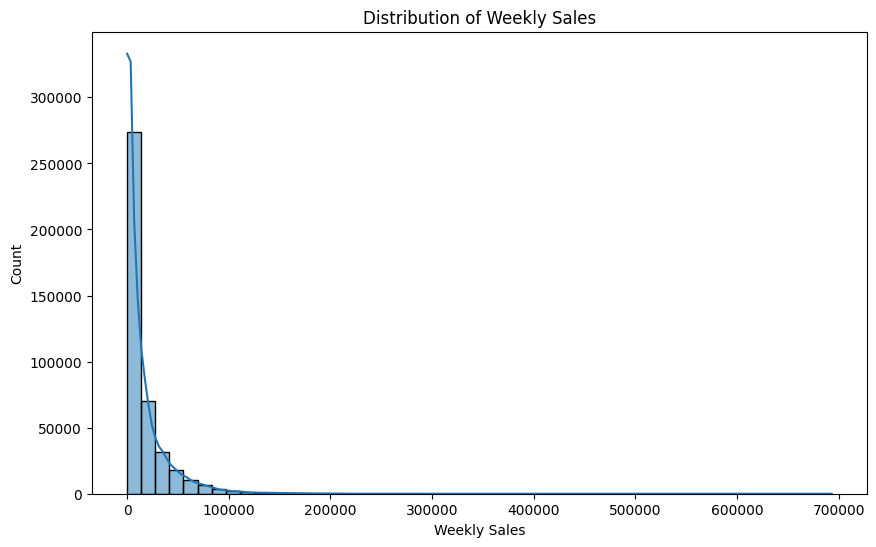

In [21]:
# creating histogram
plt.figure(figsize=(10,6))
sns.histplot(sales_data_df['Weekly_Sales'], kde = True, bins = 50)
plt.title("Distribution of Weekly Sales")
plt.xlabel('Weekly Sales')
plt.savefig('images/Distribution_of_Weekly_Sales_hist_chart.png', bbox_inches='tight')
plt.show()

**comments:**</br>weekly sales do not have a normal distribution and have a more extended rail, which indicates they are positively skewed. 

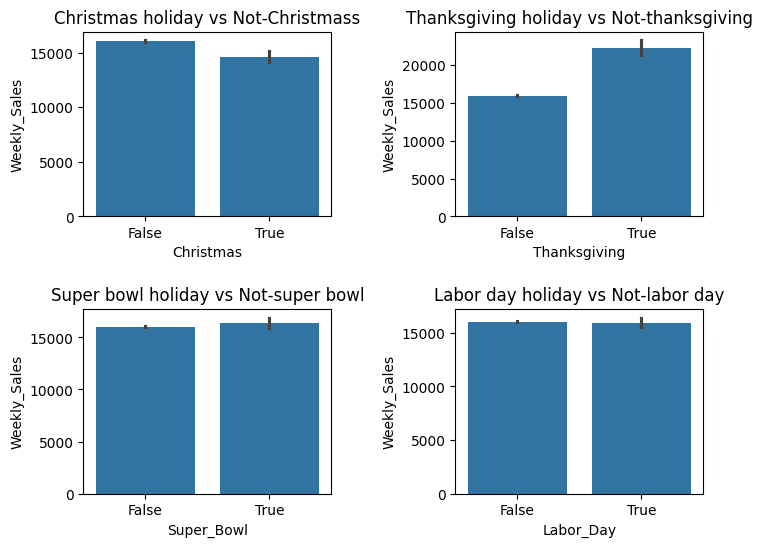

In [22]:
# creating bar plots to compare holiday week's weekly sales
fig, axes = plt.subplots(2, 2, figsize=(8,6))
sns.barplot(x='Christmas', y='Weekly_Sales', data=sales_data_df, ax=axes[0,0]).set(title='Christmas holiday vs Not-Christmass')
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=sales_data_df, ax=axes[0,1]).set(title='Thanksgiving holiday vs Not-thanksgiving')
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=sales_data_df, ax=axes[1,0]).set(title='Super bowl holiday vs Not-super bowl')
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=sales_data_df, ax=axes[1,1]).set(title='Labor day holiday vs Not-labor day')
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5)
plt.savefig('images/holiday_non_holidaay_compare_bar_chart.png', bbox_inches='tight')
plt.show() 

**comments:**</br>
The graphs show that Labor Day and Christmas do not increase weekly average sales. The Super Bowl has a positive effect on sales, but the highest difference is in Thanksgiving. The reason might be that people generally prefer to buy Christmas gifts 1-2 weeks before Christmas, so sales do not change during that week. And there are Black Friday sales during Thanksgiving week.

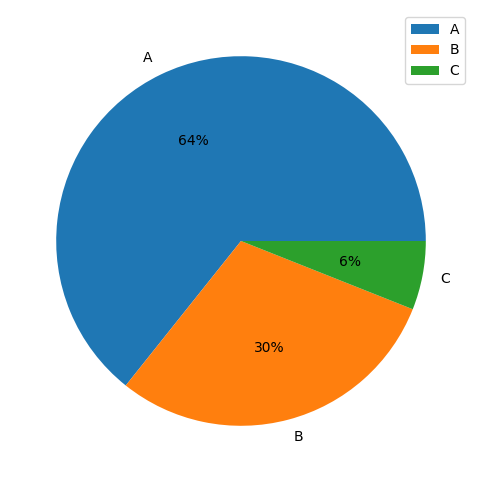

In [23]:
# Plotting the pie chart for store type
sales_data_df.groupby(['Type']).sum().plot(kind='pie', y='Weekly_Sales', autopct='%1.0f%%', figsize=(8,6)).set_ylabel('')
plt.show()

In [24]:
sales_data_df.groupby(['Type']).count()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,CPI,Unemployment,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,weekday,month,year
Type,,,,,,,,,,,,,,,,,,,,,
A,214961,214961,214961,214961,214961,214961,214961,214961,214961,214961,...,214961,214961,214961,214961,214961,214961,214961,214961,214961,214961
B,162787,162787,162787,162787,162787,162787,162787,162787,162787,162787,...,162787,162787,162787,162787,162787,162787,162787,162787,162787,162787
C,42464,42464,42464,42464,42464,42464,42464,42464,42464,42464,...,42464,42464,42464,42464,42464,42464,42464,42464,42464,42464


**Comments:**</br>The visualizations show that 64% of weekly sales are from store type A, followed by 30 % from store B and 6 % from store C. Also, the table shows that most of the observations are from store type A.

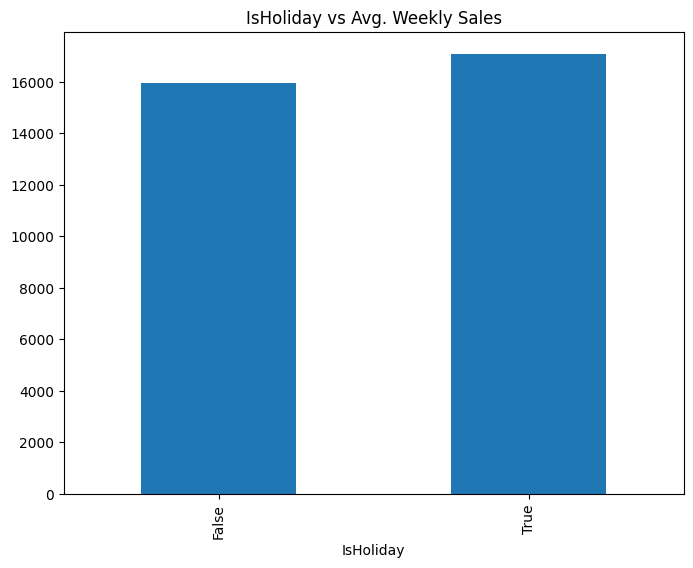

In [25]:
# Average sales by holiday
sales_data_df.groupby(['IsHoliday'])['Weekly_Sales'].mean().plot(kind='bar', y='Weekly_Sales', figsize=(8,6)).set_title('IsHoliday vs Avg. Weekly Sales')
plt.show()

In [26]:
# create dataframe for each holiday type
super_bowl_type_df = sales_data_df[sales_data_df['Super_Bowl']].groupby(['Type'])['Weekly_Sales'].mean()
labor_day_type_df = sales_data_df[sales_data_df['Labor_Day']].groupby(['Type'])['Weekly_Sales'].mean()
thanksgiving_type_df = sales_data_df[sales_data_df['Thanksgiving']].groupby(['Type'])['Weekly_Sales'].mean()
christmas_type_df = sales_data_df[sales_data_df['Christmas']].groupby(['Type'])['Weekly_Sales'].mean()

# combine all holiday types
holiday_avg_weekly_sales_by_type_df = pd.DataFrame({'super_Bowl_avg_weekly_sales': super_bowl_type_df,\
                                                    'labor_day_avg_weekly_sales': labor_day_type_df,\
                                                    'thanksgiving_avg_weekly_sales': thanksgiving_type_df,\
                                                    'christmas_avg_weekly_sales': christmas_type_df}).reset_index() 

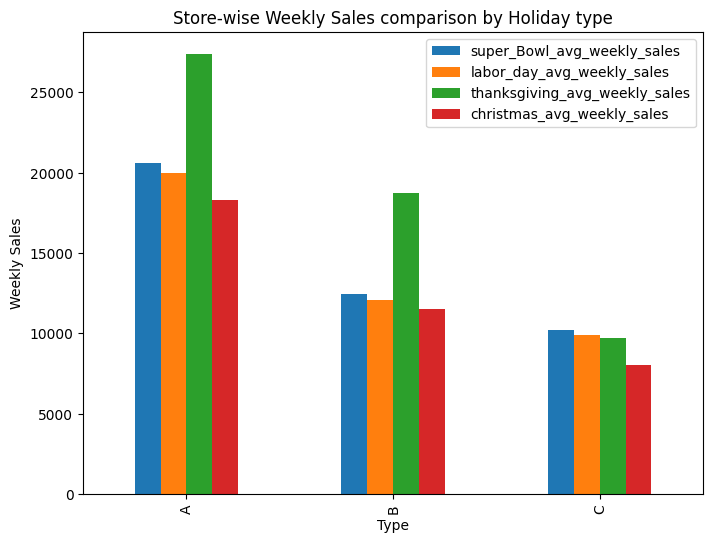

In [27]:
# plot grouped bar chart 
holiday_avg_weekly_sales_by_type_df.plot(x='Type', 
        kind='bar', 
        stacked=False, 
        title='Store-wise Weekly Sales comparison by Holiday type', figsize=(8,6)).set_ylabel('Weekly Sales')
plt.savefig('images/Store_wise_Weekly_Sales_comparison_by_Holiday_type.png', bbox_inches='tight')
plt.show()

**Comments:**</br>
The above chart shows that holidays bring a little more average sales than non-holiday weeks. Also, it is seen from the graph that the highest sale average is in the Thanksgiving week between holidays. And for all holidays, Type A stores have the highest sales.

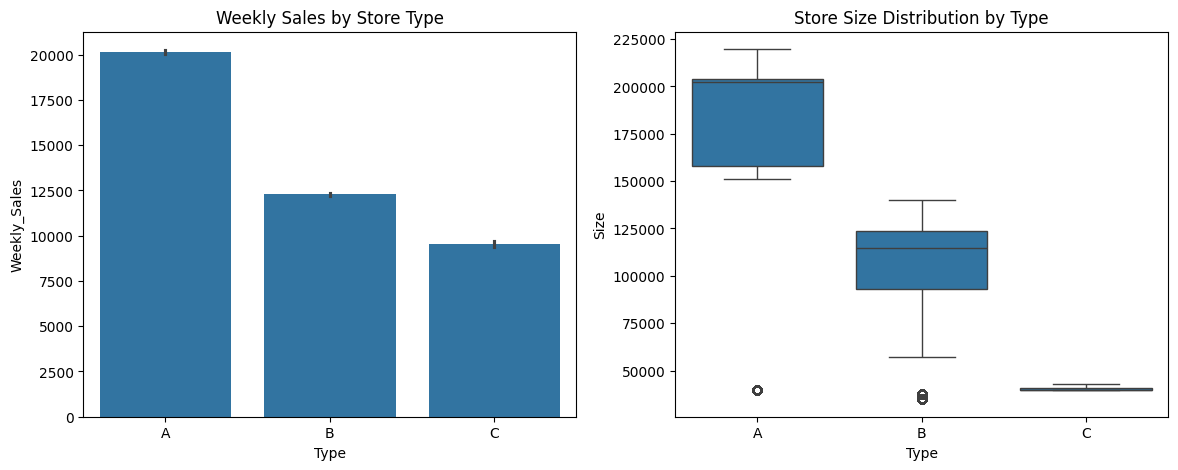

In [28]:
fig, axes = plt.subplots(nrows= 1, ncols=2, figsize=(14,5))
# sns.barplot(x='Christmas', y='Weekly_Sales', data=sales_data_df, ax=axes[0,0]).set(title='Christmas holiday vs not-Christmass')
# creating box plot for to view  the type-size relation
# plt.figure(figsize=(10,6))
sns.barplot(x='Type', y='Weekly_Sales', data=sales_data_df, ax=axes[0]).set(title='Weekly Sales by Store Type')
sns.boxplot(x='Type', y='Size', data=sales_data_df, ax=axes[1]).set(title='Store Size Distribution by Type')
# sns.boxplot(x= sales_data_df['Type'],y=sales_data_df['Size'])
# plt.title("Store Size Distribution by Type")
# plt.ylabel('Size')
# plt.xlabel('Type')
plt.subplots_adjust(wspace=0.2)
plt.savefig('images/Store_Size_Distribution_by_Type_box_chart.png', bbox_inches='tight')
plt.show()

**Comments:**</br>
The size of the types of stores is consistent with sales, as expected. Higher-sized stores have higher sales. Walmart classifies stores according to their sizes, according to the graph. After the smallest size value of Type A, Type B begins. After the smallest size value of Type B, Type C begins.

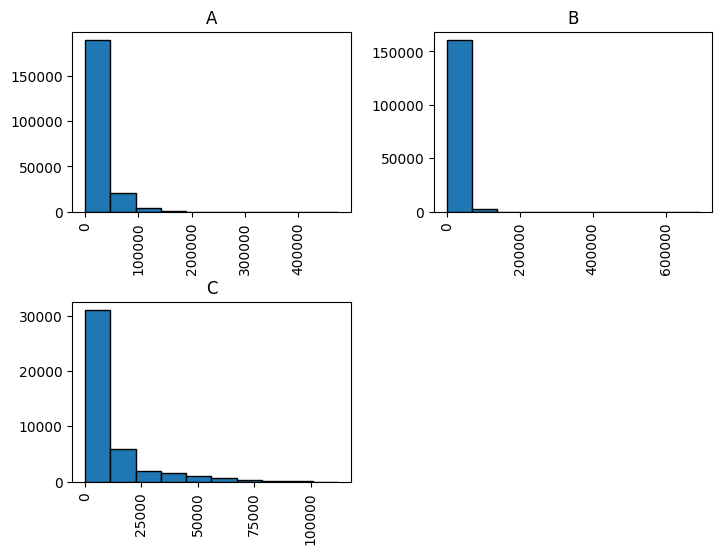

In [29]:
# creating histogram by type
sales_data_df['Weekly_Sales'].hist(by=sales_data_df['Type'], edgecolor='black', figsize = (8,6))
plt.show()

<Figure size 1400x600 with 0 Axes>

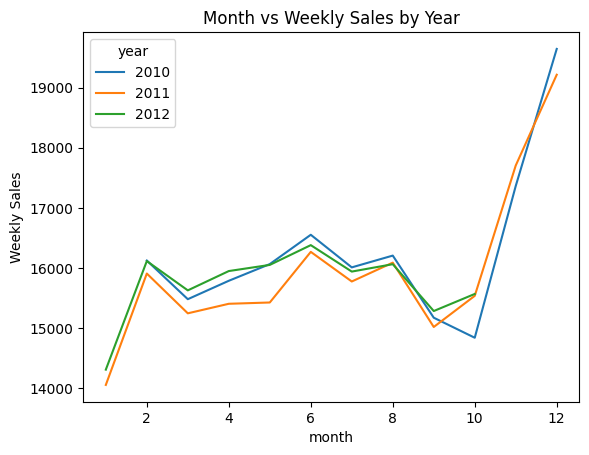

In [30]:
# creating line chart for monthwise analysis
plt.figure(figsize=(14,6))
monthly_sales = pd.pivot_table(sales_data_df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot(title='Month vs Weekly Sales by Year').set_ylabel('Weekly Sales')
plt.savefig('images/Month_vs_Weekly_Sales_by_Year_line_chart.png', bbox_inches='tight')
plt.show()

**Comments:**</br>
From the graph, it is seen that 2011 has lower sales than 2010 generally. When we look at the mean sales, it is seen that 2010 has higher values, but 2012 has no information about November and December, which have higher sales. Despite 2012 having no last two months' sales, its mean is near 2010. It will probably take first place if we get 2012 results and add them.

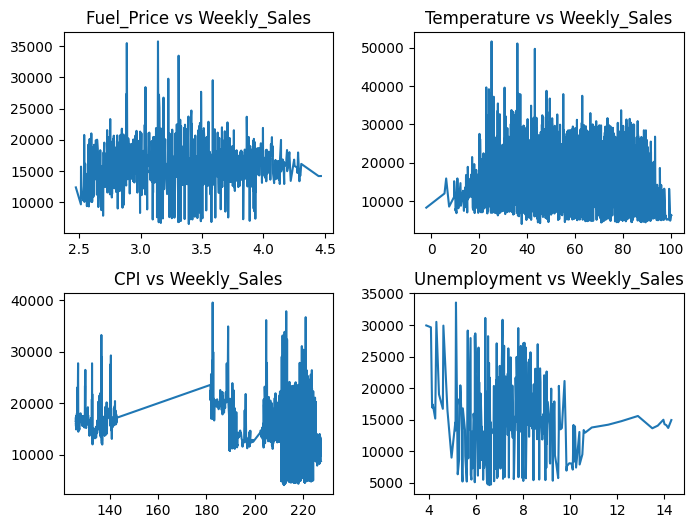

In [31]:
fuel_price = pd.pivot_table(sales_data_df, values = "Weekly_Sales", index= "Fuel_Price").reset_index()
temp = pd.pivot_table(sales_data_df, values = "Weekly_Sales", index= "Temperature").reset_index()
CPI = pd.pivot_table(sales_data_df, values = "Weekly_Sales", index= "CPI").reset_index()
unemployment = pd.pivot_table(sales_data_df, values = "Weekly_Sales", index= "Unemployment").reset_index()
# Initialise the subplot function using number of rows and columns 
figure, axis = plt.subplots(2, 2, figsize=(8,6) )
  
# For Sine Function 
axis[0, 0].plot(fuel_price["Fuel_Price"], fuel_price["Weekly_Sales"]) 
axis[0, 0].set_title("Fuel_Price vs Weekly_Sales") 
  
# For Cosine Function 
axis[0, 1].plot(temp["Temperature"], temp["Weekly_Sales"]) 
axis[0, 1].set_title("Temperature vs Weekly_Sales") 
  
# For Tangent Function 
axis[1, 0].plot(CPI["CPI"], CPI["Weekly_Sales"]) 
axis[1, 0].set_title("CPI vs Weekly_Sales") 
  
# For Tanh Function 
axis[1, 1].plot(unemployment["Unemployment"], unemployment["Weekly_Sales"]) 
axis[1, 1].set_title("Unemployment vs Weekly_Sales") 

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.savefig('images/other_feature_comparision_scatter_chart.png', bbox_inches='tight')

# Combine all the operations and display 
plt.show() 

**Comments:**</br>The graphs show no significant patterns between CPI, temperature, unemployment rate, and fuel price vs. weekly sales. There is also no data for CPI between 140 and 180.

<div style="text-align: center;"> <h1>Modeling</h1> </div>

<div style="text-align: left;"> <h2>Time series stationary check</h2> </div>

P-value before applying differencing technique: 1.783387695155416e-15
P-value before After differencing technique: 0.0


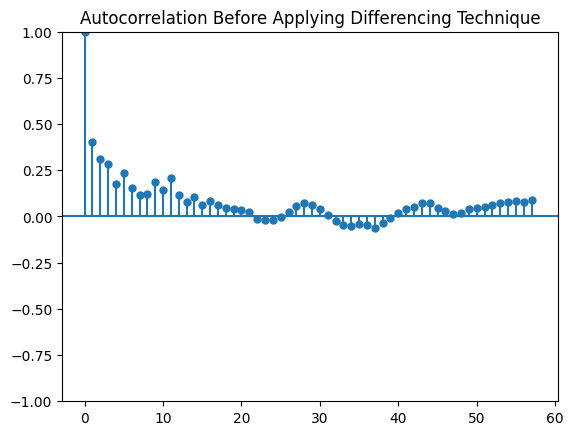

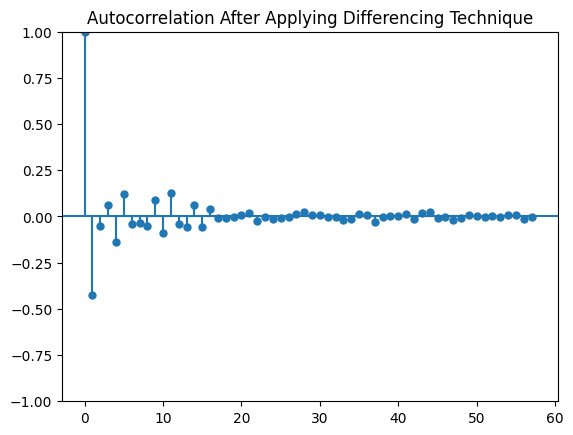

In [32]:
# plot acf chart
plot_acf(sales_data_df['Weekly_Sales'].dropna(),title='Autocorrelation Before Applying Differencing Technique')

# using adfuller test to find if the data is stationary or not
adfuller_test_result=adfuller(sales_data_df['Weekly_Sales'])
print(f"P-value before applying differencing technique: {adfuller_test_result[1]}")

# creating acf plot with once difference
plot_acf(sales_data_df['Weekly_Sales'].diff().dropna(),title='Autocorrelation After Applying Differencing Technique')

# making data stationary and testing teh P-value
adfuller_test_result_d1=adfuller(sales_data_df['Weekly_Sales'].diff().dropna())
print(f"P-value before After differencing technique: {adfuller_test_result_d1[1]}")

**commnets:**</br>From the autocorrelation function(ACF) plot and statistical test, the augmented dickey-fuller test found that series data is stationary and hence used the differencing technique to make it nonstationary.

<Figure size 1600x600 with 0 Axes>

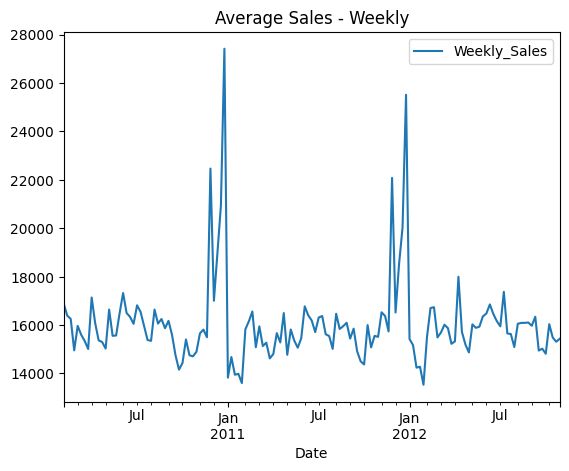

In [33]:
sales_data_weekly_df = pd.DataFrame(sales_data_df.Weekly_Sales.resample('W').mean()) #resample data as weekly
plt.figure(figsize=(16,6))
sales_data_weekly_df.plot()
plt.title('Average Sales - Weekly')
plt.show()

<Figure size 1600x600 with 0 Axes>

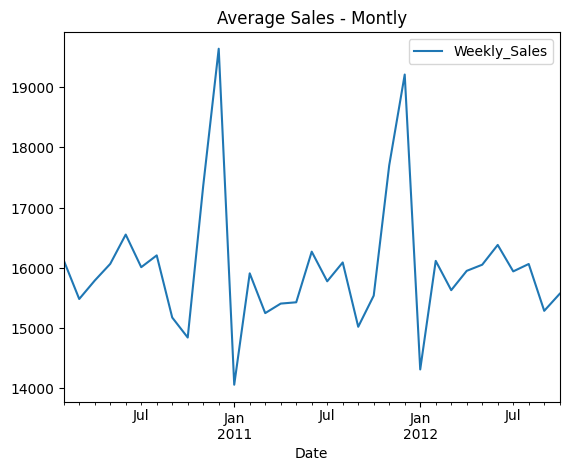

In [34]:
sales_data_monthly_df = pd.DataFrame(sales_data_df.Weekly_Sales.resample('MS').mean()) #resample data as weekly
plt.figure(figsize=(16,6))
sales_data_monthly_df.plot()
plt.title('Average Sales - Montly')
plt.show()

**Comments:**</br>
Three years of historical data have been resampled to aggregate at the weekly and monthly levels. From the comparison, it has been identified that monthly level aggregation is missing some pattern from weekly, and hence, weekly aggregation was selected for this model building. 

<div style="text-align: left;"> <h2>Time series seasonality check</h2> </div>

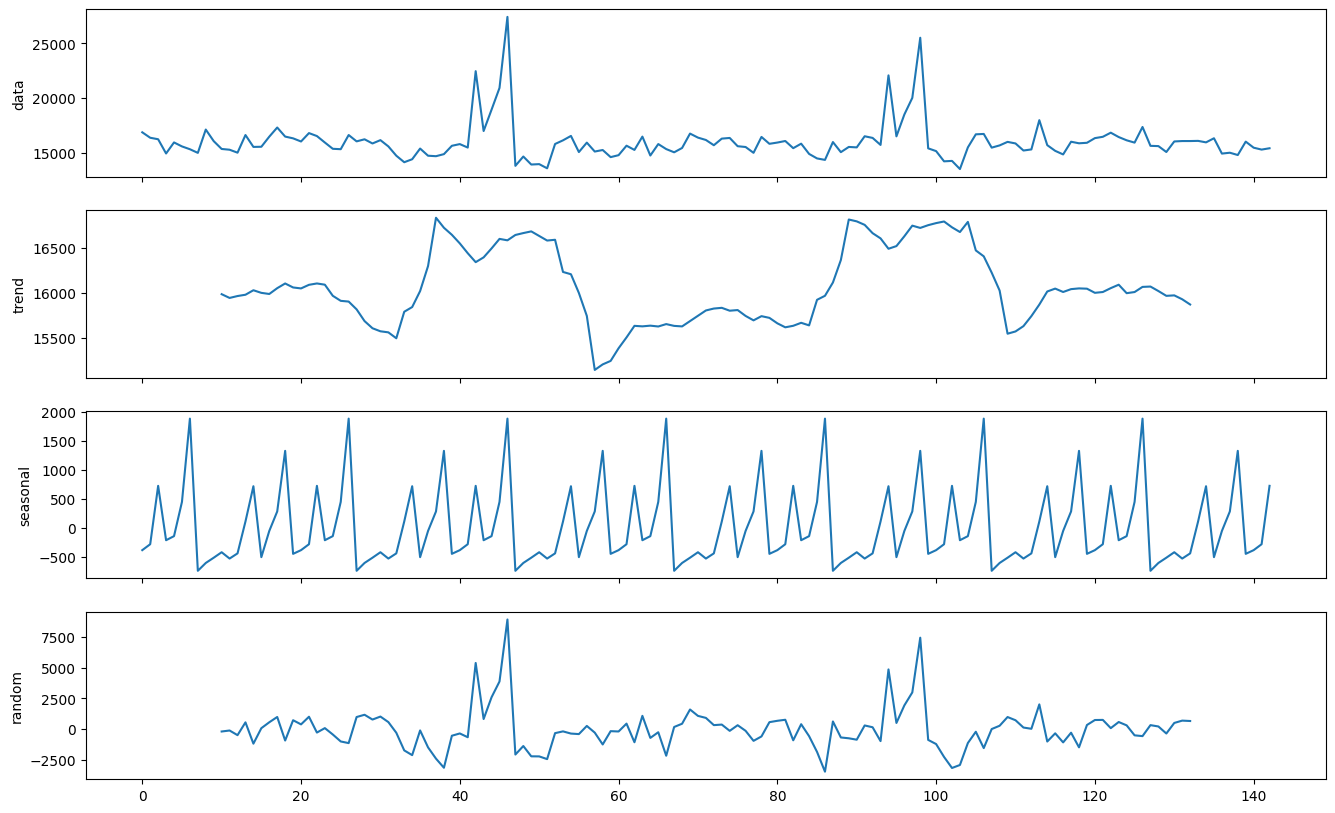

In [35]:
decomposed = decompose(sales_data_weekly_df['Weekly_Sales'].values, 'additive', m=20)
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

**comments:**</br>Decomposition has been applied to the weekly data sets to identify seasonality. It has been determined that every 20-step seasonality converges to the beginning point

<div style="text-align: left;"> <h2>Train Split Data</h2> </div>

In [36]:
train_data = sales_data_weekly_df[:int(0.7*(len(sales_data_weekly_df)))]
test_data = sales_data_weekly_df[int(0.7*(len(sales_data_weekly_df))):]

In [393]:
def performance_evaluation(test_data_set, y_pred_detail,title,skip_plot):
    rmse = sqrt(mean_squared_error(test_data_set,y_pred_detail))
    mae = mean_absolute_error(test_data_set,y_pred_detail)
    mape = mean_absolute_percentage_error(test_data_set,y_pred_detail)
    print(f'rmse: {rmse}')
    print(f'mae: {mae}')
    print(f'mape: {mape}')
    if not skip_plot:
        plt.figure(figsize=(14,6))
        
    
        # plot results
        plt.plot(test_data_set.index, test_data_set['Weekly_Sales'], label='Actual')
        plt.plot(test_data_set.index,y_pred_detail['Prediction'], color='red', label='Forecast')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.title(title)
        plt.legend()
        plt.savefig('images/'+title, bbox_inches='tight')
        plt.show()    
        

In [396]:
# buildiing ARIMA

def perform_arima(sales_dataset,skip_plot):
    train_data_diff = pd.DataFrame(sales_dataset[:int(0.7*(len(sales_dataset )))])
    test_data_diff = pd.DataFrame(sales_dataset[int(0.7*(len(sales_dataset ))):])    
    model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                      max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                      information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                      error_action='ignore',approximation = False)    
    # # Fit an ARIMA model to the training data
    # model_arima=ARIMA(train_data_diff,order=(0,0,4))
    # model_arima_fit=model_arima.fit()
    model_auto_arima.fit(train_data_diff)    
    # Predictions
    y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
    y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])  
    performance_evaluation(test_data, y_pred,'ARIMA Forecasting with Prediction Intervals',skip_plot)  

In [398]:
perform_arima(sales_data_weekly_df, False)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1813.025, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1807.863, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1806.051, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1805.480, Time=0.10 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1782.969, Time=0.13 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.632, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=1805.301, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1807.815, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=1808.903, Time=0.05 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1785.800, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1803.865, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1805.884, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1804.457, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1801.899, Time=0.13 sec
 ARIMA(3,0,0)(0

**LSTM**

In [202]:
#creating difference values to make data stationary 
sales_data_weekly_diff_df = sales_data_weekly_df['Weekly_Sales'].diff().dropna() 

#create a new dataframe to model the difference
df_diff = sales_data_weekly_df.copy().reset_index()
#add previous sales to the next row
df_diff['prev_weekly_Sales'] = df_diff['Weekly_Sales'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['Weekly_Sales'] - df_diff['prev_weekly_Sales'])
df_diff.head(5)

,Date,Weekly_Sales,prev_weekly_Sales,diff
1,2010-02-14,16390.912208,16887.602166,-496.689958
2,2010-02-21,16255.185970,16390.912208,-135.726238
3,2010-02-28,14955.932194,16255.185970,-1299.253776
4,2010-03-07,15964.821240,14955.932194,1008.889046
5,2010-03-14,15600.149905,15964.821240,-364.671335


In [371]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_weekly_Sales'],axis=1)
#adding lags
for inc in range(1,54):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)
df_supervised.columns

# df_supervised_sale = df_supervised.copy().reset_index()

df_supervised_sale = df_supervised[['Date','Weekly_Sales']]
df_supervised_sale.set_index('Date', inplace=True) 
                          
# df_supervised_sale.set_index('Date', inplace=True) 

df_model = df_supervised.drop(['Weekly_Sales','Date'],axis=1)

In [399]:
# building LSTM

def perform_lstm(sales_dataset,neurons,batch_size,nb_epoch,drop_out,dense,skip_plot):
    #split train and test set
    lstm_train = sales_dataset[:int(0.7*(len(sales_dataset)))] 
    lstm_test = sales_dataset[int(0.7*(len(sales_dataset))):]
    
    lstm_train_data = sales_dataset[:int(0.7*(len(sales_dataset)))] .values
    lstm_test_data = sales_dataset[int(0.7*(len(sales_dataset))):].values
    
   
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(lstm_train_data)
    # reshape training set
    lstm_train_data = lstm_train_data.reshape(lstm_train_data.shape[0], lstm_train_data.shape[1])
    train_set_scaled = scaler.transform(lstm_train_data)
    # reshape test set
    lstm_test_data = lstm_test_data.reshape(lstm_test_data.shape[0], lstm_test_data.shape[1])
    test_set_scaled = scaler.transform(lstm_test_data)
    
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])     

    seed = 42
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

    # prepare model
    model = Sequential()
    model.add(LSTM(neurons,return_sequences=True, input_shape=( X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(drop_out))
    model.add(Dense(units=dense))
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])


    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

    # fit model
    model.fit(X_train, y_train, validation_split=0.2, epochs=nb_epoch, batch_size=batch_size, verbose=0, callbacks=[es])

    test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test set Accuracy: {test_accuracy}')

    y_pred_lstm = model.predict(X_test,batch_size=batch_size)
    #for multistep prediction, you need to replace X_test values with the predictions coming from t-1

    #reshape y_pred
    y_pred_lstm = y_pred_lstm.reshape(y_pred_lstm.shape[0], 1, y_pred_lstm.shape[1])
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred_lstm)):
        np.concatenate([y_pred_lstm[index],X_test[index]],axis=1)
        pred_test_set.append(np.concatenate([y_pred_lstm[index],X_test[index]],axis=1))
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    #inverse transform
    pred_test_set_inverted = scaler.inverse_transform(pred_test_set)
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(df_supervised_sale[int(0.7*(len(df_supervised_sale))):].index)
    act_sales = list(df_supervised_sale[int(0.7*(len(df_supervised_sale))):]['Weekly_Sales'])

    
    for index in range(0,len(pred_test_set_inverted)):
        result_dict = {}
        result_dict['Prediction'] = int(pred_test_set_inverted[index][0] + act_sales[index])
        result_dict['Date'] = sales_dates[index]
        result_list.append(result_dict)
    df_result = pd.DataFrame(result_list)
    df_result.set_index('Date', inplace=True)
    actutal_df = df_result.join(df_supervised_sale)
    actutal_df = actutal_df.drop(['Prediction'],axis=1)

# performance evalutaion 
    performance_evaluation(actutal_df, df_result,'LSTM Forecasting with Prediction Intervals',skip_plot)
    return test_accuracy

Test set Accuracy: [0.0137293990701437, 0.11717251688241959]
7/7 [==============================] - 0s 2ms/step
rmse: 607.4867647513946
mae: 544.6398867279668
mape: 0.034233461533296566


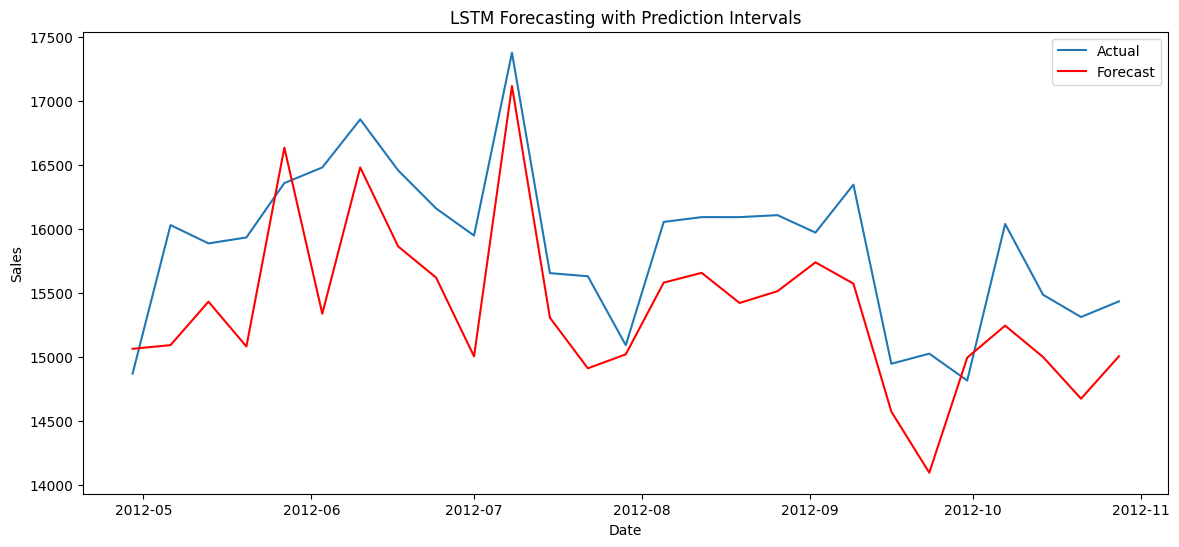

In [400]:
initial_test_accuracy =perform_lstm(df_model,1,4,10,0.2,1,False)

In [380]:
# hyper parameter tuning

def lstm_hyperParameter_tuning(sales_dataset,config):
    lstm_train = sales_dataset[:int(0.7*(len(sales_dataset)))] 
    lstm_test = sales_dataset[int(0.7*(len(sales_dataset))):]
    
    lstm_train_data = sales_dataset[:int(0.7*(len(sales_dataset)))] .values
    lstm_test_data = sales_dataset[int(0.7*(len(sales_dataset))):].values  
    
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(lstm_train_data)
    # reshape training set
    lstm_train_data = lstm_train_data.reshape(lstm_train_data.shape[0], lstm_train_data.shape[1])
    train_set_scaled = scaler.transform(lstm_train_data)
    # reshape test set
    lstm_test_data = lstm_test_data.reshape(lstm_test_data.shape[0], lstm_test_data.shape[1])
    test_set_scaled = scaler.transform(lstm_test_data)
    
    
    x_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
    x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
    x_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
    x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])       
    
    n_neurons,n_batch_size, dropout = config
    possible_combinations = list(itertools.product(n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []

    
    for i in range(0, len(possible_combinations)):
        
        
        n_neurons, n_batch_size, dropout = possible_combinations[i]
        seed = 42
        np.random.seed(seed)
        tf.random.set_seed(seed)
        random.seed(seed)
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        # regressor.add(LSTM(units=n_neurons, return_sequences=False))
        # regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1))
        regressor.compile(optimizer='adam', loss='mse')

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=0, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)
        

        hist.append(list((n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

         
    return hist

In [383]:
# config = [ [2,10,25,50], [4,8,16,32], [0.2]]  

config = [ [1,2,4], [2,4,8], [0.2]]  


# list of lists --> [[n_neurons], [n_batch_size], [dropout]]

model_eval_hist = lstm_hyperParameter_tuning(df_model,config)  # change x_train shape



[(1, 2, 0.2), (1, 4, 0.2), (1, 8, 0.2), (2, 2, 0.2), (2, 4, 0.2), (2, 8, 0.2), (4, 2, 0.2), (4, 4, 0.2), (4, 8, 0.2)]




In [384]:
model_eval_hist = pd.DataFrame(model_eval_hist)
model_eval_hist.columns = ['neurons','batch_size', 'dropout',
                          'train_accuracy', 'test_accuracy']
model_eval_hist = model_eval_hist.sort_values(by=['test_accuracy'], ascending=False)
model_eval_hist

,neurons,batch_size,dropout,train_accuracy,test_accuracy
1,1,4,0.2,0.032318,0.017165
2,1,8,0.2,0.027579,0.012158
4,2,4,0.2,0.024347,0.011096
0,1,2,0.2,0.025279,0.010573
3,2,2,0.2,0.022317,0.009636
5,2,8,0.2,0.023385,0.009635
7,4,4,0.2,0.019250,0.005344
8,4,8,0.2,0.016719,0.002355
6,4,2,0.2,0.015841,0.002082


In [386]:
print(f'Best Combination: \n n_neurons = {model_eval_hist.iloc[0, 0]}\n n_batch_size = {model_eval_hist.iloc[0, 1]}\n dropout = {model_eval_hist.iloc[0, 2]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(initial_test_accuracy, 4)}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(model_eval_hist.iloc[0, -1], 4)}\n')
print(f'{(np.round(model_eval_hist.iloc[0, -1], 4)- np.round(initial_test_accuracy, 4))*100/np.round(initial_test_accuracy, 4)}% Improvement')

Best Combination: 
 n_neurons = 1
 n_batch_size = 4
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: [0.0137 0.1172]

Results After Tunning:
 Test Set RMSE: 0.0172

[ 25.54744526 -85.32423208]% Improvement


In [405]:
for index, row in model_eval_hist.iterrows():
    neurons = int(row['neurons'])
    batch_size = int(row['batch_size'])
    dropout = row['dropout']
    print(f'neurons={neurons},batch_size={batch_size},dropout={dropout}')
    perform_lstm(df_model,int(row['neurons']),int(row['batch_size']),10,row['dropout'],1, True)


neurons=1,batch_size=4,dropout=0.2
Test set Accuracy: [0.0137293990701437, 0.11717251688241959]
7/7 [==============================] - 0s 86us/step
rmse: 607.4867647513946
mae: 544.6398867279668
mape: 0.034233461533296566
neurons=1,batch_size=8,dropout=0.2
Test set Accuracy: [0.021012436598539352, 0.14495667815208435]
4/4 [==============================] - 0s 666us/step
rmse: 918.6566374678519
mae: 833.146390505913
mape: 0.052336551464812524
neurons=2,batch_size=4,dropout=0.2
Test set Accuracy: [0.00812141876667738, 0.09011891484260559]
7/7 [==============================] - 0s 833us/step
rmse: 353.5909593417724
mae: 289.5907028134622
mape: 0.018341543528106168
neurons=1,batch_size=2,dropout=0.2
Test set Accuracy: [0.010445339605212212, 0.10220244526863098]
14/14 [==============================] - 0s 692us/step
rmse: 411.35062241850665
mae: 365.84838760983774
mape: 0.023088241330426522
neurons=2,batch_size=2,dropout=0.2
Test set Accuracy: [0.006790982559323311, 0.08240741491317749]
14/

Test set Accuracy: [0.006790982559323311, 0.08240741491317749]
14/14 [==============================] - 1s 827us/step
rmse: 280.3855606674664
mae: 235.0754349898577
mape: 0.014876274142565702


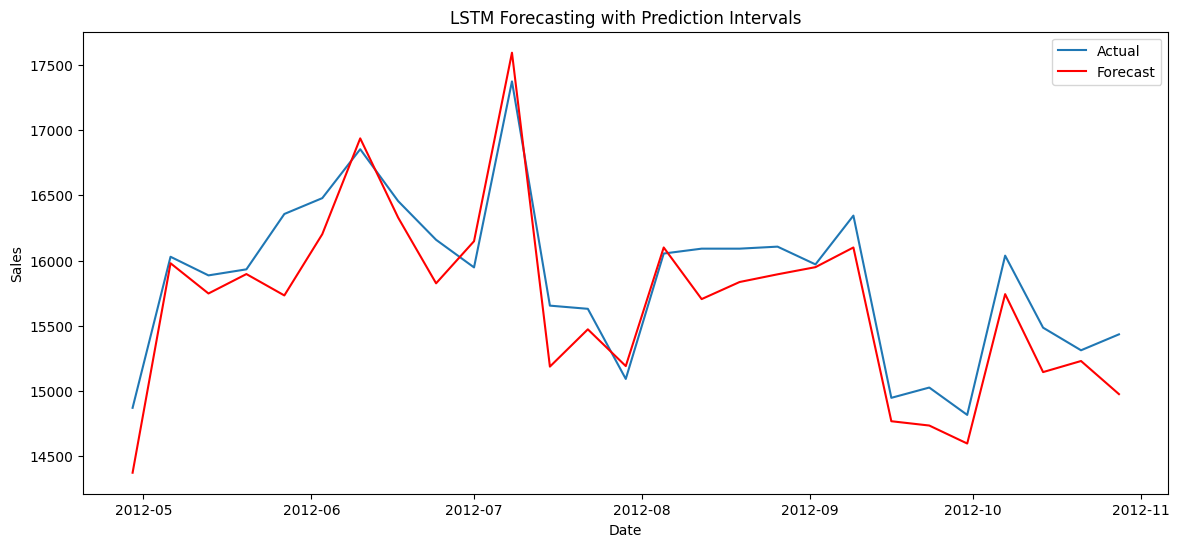

[0.006790982559323311, 0.08240741491317749]

In [406]:
# After running multiple test below yield better RMSE
perform_lstm(df_model,2,2,10,0.2,1,False)